In [ ]:
# %pip install gensim

### **1. Import Libraries**

In [1]:

import re
import nltk
import string

import pandas as pd
import numpy as np
from nltk.corpus import stopwords

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from collections import defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sroor For
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
path = r"C:\Users\Sroor For Laptop\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1"
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Sroor For Laptop\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1


In [3]:
df = pd.read_csv(f"{path}/spam.csv", encoding='latin-1')

### **2. Reading Dataset**

In [ ]:
# Rename columns
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)


# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

# Generate tokens for analysis
from nltk.tokenize import word_tokenize
df['clean_tokens'] = df['cleaned_text'].apply(word_tokenize)

### **4. Data Preprocessing & Feature Extraction**

In [ ]:

# 1. Binary Encoding (Presence/Absence)
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
X_binary = binary_vectorizer.fit_transform(df['cleaned_text'])
print("Binary Encoding Shape:", X_binary.shape)


In [ ]:

# 2. Count Vectorization (Bag of Words)
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(df['cleaned_text'])
print("Count Vectorization Shape:", X_count.shape)


In [ ]:

# 3. TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print("TF-IDF Shape:", X_tfidf.shape)


In [ ]:

# 4. Word2Vec
from gensim.models import Word2Vec

# Prepare data for Word2Vec (list of lists of words)
tokenized_sentences = df['cleaned_text'].apply(word_tokenize).tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to average word vectors for a sentence
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    if not doc:
        return np.zeros(100)
    return np.mean(w2v_model.wv[doc], axis=0)

X_word2vec = np.array([document_vector(doc) for doc in tokenized_sentences])
print("Word2Vec Shape:", X_word2vec.shape)


In [19]:
# 1. Extract features and labels
X = df['text']
y = df['label'].map({'ham': 0, 'spam': 1})

# -------------------------------------------------
# 2. Train-test split (stratified to keep imbalance)
# -------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------
# 3. TF-IDF vectorization
#    Fit on train ONLY ➝ transform test
# -----------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=clean_text)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

# -------------------------------------------------
# 4. Undersampling (apply on training only)
# -------------------------------------------------


# rus = RandomUnderSampler(random_state=42)
# X_train_res, y_train_res = rus.fit_resample(X_train_vec, y_train)
# Fallback for Resampling
if 'X_train_res' not in locals():
    X_train_res = X_train
    y_train_res = y_train

d:\programs\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### **Feature Extraction Techniques**

### **5. Model Training and Evaluation**

In [ ]:

# Function to train and evaluate models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='spam')
    recall = recall_score(y_test, y_pred, pos_label='spam')
    f1 = f1_score(y_test, y_pred, pos_label='spam')
    
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)
    
    return model, y_pred


In [ ]:

# Split Data (using TF-IDF as the primary feature set for comparison)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

# Initialize Models
nb_model = MultinomialNB()
svm_model = SVC(kernel='linear')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and Evaluate
print("Evaluating Models on TF-IDF Features:")
nb_trained, _ = train_evaluate_model(nb_model, X_train, X_test, y_train, y_test, "Naive Bayes")
svm_trained, pred_svm = train_evaluate_model(svm_model, X_train, X_test, y_train, y_test, "SVM")
rf_trained, _ = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")


Confusion Matrix:
 [[943  23]
 [ 13 136]]


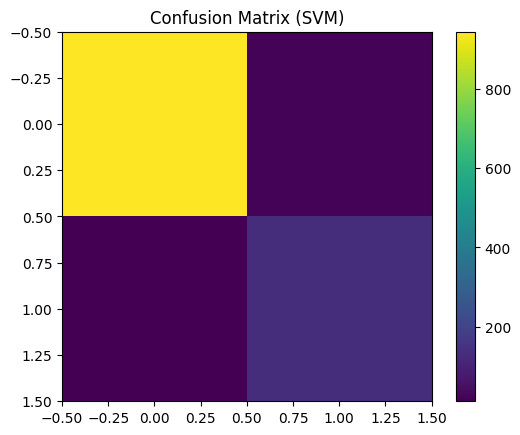

In [45]:
cm = confusion_matrix(y_test, pred_svm)
print("Confusion Matrix:\n", cm)
plt.imshow(cm)
plt.title("Confusion Matrix (SVM)")
plt.colorbar()
plt.show()

In [ ]:

# Save the best model (e.g., SVM) and vectorizer for deployment
import joblib
import os

if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(svm_trained, 'models/spam_svm_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
print("Model and Vectorizer saved to 'models/' directory.")
